## Imports

In [ ]:
# Import necessary libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

import pandas as pd

### Seed

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

## Load data
Load data and target arrays from '.npy' files
- data: (number_of_images, 224, 224)
- target: (number_of_images, 1)

In [ ]:
data = np.load('/path/data_file_name.npy')
target = np.load('/path/target_file_name.npy')

### Split data
1. Splits the data into training and testing sets using 'train_test_split' from scikit-learn.
- 'data' contains the input data.
- 'target' contains the corresponding target values or labels.
- 'test_size' specifies the proportion of the data to be used for validation (in this case, 15%).
- 'random_state' is used to ensure reproducibility.
- 'shuffle=True' shuffles the data before splitting.

In [ ]:
# Split Data into Training and Testing Sets
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size= 0.15, random_state= seed, shuffle=True)

# Reshape the Training and Testing Data
x_train = x_train.reshape(x_train.shape[0],224,224,1)
x_test = x_test.reshape(x_test.shape[0],224,224,1)

# Print Shapes of the Split and Reshaped Data
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

1. Converts the 'y_train' array, which contains target values, into a DataFrame called 'df_y_train'.
2. Calls the 'value_counts()' function on the DataFrame to count the occurrences of each unique value in 'y_train'.
- This is useful for understanding the distribution of target values in the training data.
- The result will show the count of each unique value along with their respective frequencies.

In [ ]:
# Create a DataFrame from y_train
df_y_train = pd.DataFrame(y_train)
# Count the occurrences of each unique value in the DataFrame
df_y_train.value_counts()

2    2785
1     861
0     836
dtype: int64

In [ ]:
# Print the Maximum and Minimum Values in Training and Validation Data
print(np.max(x_train), np.min(x_train))
print(np.max(x_test), np.min(x_test))

255.0 0.0
255.0 0.0


### Normalize between -1 and 1

In [ ]:
def normalize(x_train, x_test):
    """
    Normalize the pixel values in the input training and validation data.

    Args:
        x_train (numpy.ndarray): Training data containing pixel values.
        x_test (numpy.ndarray): Validation data containing pixel values.

    Returns:
        tuple: A tuple containing the normalized training and validation data.
    """
    x_train = (x_train - 127.5) / 127.5
    x_test = (x_test - 127.5) / 127.5

    return x_train, x_test

### Show images

2


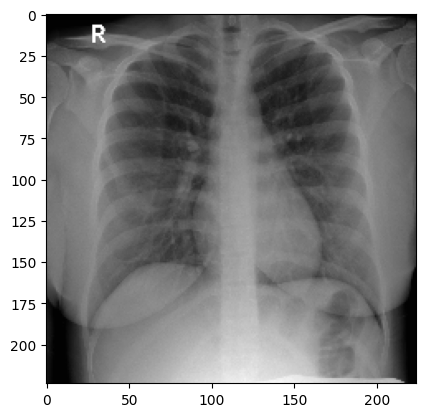

In [ ]:
# Display an Image from the Validation Data
plt.imshow(x_test[1,:,:,0],'gray')
print(y_train[1])

## One hot vector

In [ ]:
def one_hot_encoding(y_train, y_test):
    """
    Perform one-hot encoding on target labels.

    Args:
        y_train (numpy.ndarray): Training target labels.
        y_test (numpy.ndarray): Testing target labels.

    Returns:
        tuple: A tuple containing the one-hot encoded training and testing labels.
    """
    y_train_encoded = np_utils.to_categorical(y_train)
    y_test_encoded = np_utils.to_categorical(y_test)

    num_classes = y_test_encoded.shape[1]  # Number of classes

    return y_train_encoded, y_test_encoded

## Model

In [ ]:
def selfAttention(image, len_of_W, reshape, name):
    """
    Apply self-attention mechanism to an input image.

    Args:
        image (tensorflow.Tensor): Input image tensor.
        len_of_W (int): Length of the window or kernel size for convolution.
        reshape (list): List specifying the desired shape after reshaping.
        name (str): A name prefix for the layers in the self-attention mechanism.

    Returns:
        tensorflow.Tensor: A tensor representing the result of the self-attention operation.
    """
    # Q Layer
    Q = Conv2D(1, (len_of_W, len_of_W), activation='relu', padding='same', name='Q_'+name)(image)
    Q = Reshape(reshape, name='Q_Reshape_'+name)(Q)

    # K Layer
    K = Conv2D(1, (len_of_W, len_of_W), activation='relu', padding='same', name='K_'+name)(image)
    K = Reshape(reshape, name='K_Reshape_'+name)(K)

    # V Layer
    V = Conv2D(1, (len_of_W, len_of_W), activation='relu', padding='same', name='V_'+name)(image)
    V = Reshape(reshape, name='V_Reshape_'+name)(V)

    # Calculate QK^T (Dot product of Q and the transpose of K)
    QKT = Dot(axes=(2, 2), name='dot_product_QKT_'+name)([Q, K])

    # Normalize using sqrt(224) and apply softmax
    NQKT = tf.divide(QKT, np.sqrt(224))  # Assuming 224 is the input image size

    # Apply softmax to obtain attention scores
    ATTM = Softmax(name='softmax_'+name)(NQKT)

    # Compute weighted sum using the attention scores and V
    SelfAtt = Dot(axes=(2, 1), name='selfAttention_'+name)([ATTM, V])

    # Reshape the result for further convolution
    SelfAtt = Reshape(reshape+[1], name='Reshape2conv_'+name)(SelfAtt)

    return SelfAtt


In [ ]:
def multihead_attention(input, number_of_heads, index, ker):
    """
    Apply multi-head self-attention mechanism to an input tensor.

    Args:
        input (tensorflow.Tensor): Input tensor.
        number_of_heads (int): Number of attention heads to use.
        index (int): Index to distinguish between multiple multi-head attention instances.
        ker (int): Length of the window or kernel size for convolution in the self-attention mechanism.

    Returns:
        tensorflow.Tensor: A tensor representing the result of the multi-head self-attention operation.
    """
    selfAtt = []

    # Loop to create multiple self-attention heads
    for i in range(index * number_of_heads, number_of_heads * (index + 1)):
        selfAtt.append(selfAttention(input, ker, np.shape(input)[1:3], str(i)))

    # Concatenate the results if there are multiple heads
    if number_of_heads == 1:
        concatted = selfAtt[0]
    else:
        concatted = tf.keras.layers.Concatenate()(selfAtt)

    return concatted


In [ ]:
def encoder(input, input_conv, index, ker):
    """
    Apply an encoder operation on the input tensor.

    Args:
        input (tensorflow.Tensor): Input tensor.
        input_conv (tensorflow.Tensor): Input tensor to the convolutional layer.
        index (int): Index to distinguish between multiple encoder instances.
        ker (int): Length of the window or kernel size for convolution.

    Returns:
        tensorflow.Tensor: A tensor representing the result of the encoder operation.
    """
    multihead_attention_output = multihead_attention(input_conv, 5, index, ker)  # Number of heads

    conv = Conv2D(1, (5, 5), activation='relu', padding='same')(multihead_attention_output)

    # Add the residual connection to the original input tensor
    residual_layer = tf.keras.layers.Add()([input, conv])

    return residual_layer


In [ ]:
def create_model():
    """
    Create a deep learning model for image classification.

    Returns:
        tensorflow.keras.models.Model: A compiled neural network model for image classification.
    """
    ker = 5  # Kernel size

    # Define input layer with shape (224, 224, 1)
    input = Input(shape=(224, 224, 1), name='input')

    # First convolutional layer
    conv = Conv2D(16, (5, 5), activation='relu', padding='same', name='Conv_2')(input)

    # First encoder operation
    encoder_output = encoder(input, conv, 0, ker)
    encoder_output = Dropout(0.1, seed=seed)(encoder_output)

    # Second convolutional layer
    conv = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv_3')(encoder_output)

    # Second encoder operation
    encoder_output = encoder(input, conv, 1, ker)
    encoder_output = Dropout(0.1, seed=seed)(encoder_output)

    # Max-pooling layer
    maxpool = MaxPooling2D(pool_size=(2, 2))(encoder_output)

    # Third convolutional layer
    conv = Conv2D(16, (3, 3), activation='relu', name='Conv_4')(maxpool)

    # Second max-pooling layer
    maxpool = MaxPooling2D(pool_size=(2, 2))(conv)

    # Flatten layer
    flatten = Flatten()(maxpool)

    # First dropout layer
    dropout = Dropout(0.3, seed=seed)(flatten)

    # First dense layer
    dense = Dense(256, activation='relu')(dropout)

    # Second dropout layer
    dropout = Dropout(0.3, seed=seed)(dense)

    # Second dense layer
    dense = Dense(128, activation='relu')(dropout)

    # Output layer with softmax activation for classification
    output = Dense(3, activation='softmax')(dense)

    # Create the neural network model
    model = Model(input, output)

    # Compile the model with SGD optimizer, categorical cross-entropy loss, and accuracy metric
    opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary and save its visualization to a file
    print(model.summary())
    plot_model(model, to_file='model.jpg', show_shapes=True)

    return model


In [ ]:
def checkpoint(path):
    """
    Create callbacks for model checkpointing and early stopping during training.

    Args:
        path (str): Filepath to save model checkpoints.

    Returns:
        tuple: A tuple containing checkpoint-related callbacks and the specified checkpoint file path.

    This function sets up callbacks for model checkpointing and early stopping during model training. It creates
    four callbacks:
    1. ModelCheckpoint: Saves the model's weights when validation accuracy reaches its maximum.
    2. EarlyStopping based on validation accuracy: Stops training if validation accuracy does not improve for a
       specified number of epochs (patience).
    3. EarlyStopping based on validation loss: Stops training if validation loss does not improve for a specified
       number of epochs (patience).
    """
    checkpoint_filepath = path

    # ModelCheckpoint callback
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,  # Save entire model, not just weights
        monitor='val_accuracy',
        mode='max',
        save_best_only=True  # Save only the best model
    )

    # EarlyStopping callback based on validation accuracy
    early_stopping_acc = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=50,  # Number of epochs with no improvement before stopping
        verbose=0,
        mode="max",
        restore_best_weights=False  # Do not restore weights to the best model
    )

    # EarlyStopping callback based on validation loss
    early_stopping_loss = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=50,  # Number of epochs with no improvement before stopping
        verbose=0,
        mode="min",
        restore_best_weights=False  # Do not restore weights to the best model
    )

    return checkpoint_filepath, model_checkpoint_callback, early_stopping_acc, early_stopping_loss


In [ ]:
def train_model(model, checkpoint_filepath, model_checkpoint_callback, early_stopping_acc, early_stopping_loss, x_train, y_train2, x_test, y_test2):
    """
    Train a deep learning model with checkpoints and early stopping.

    Args:
        model (tensorflow.keras.models.Model): The neural network model to be trained.
        checkpoint_filepath (str): Filepath to save model checkpoints.
        model_checkpoint_callback (tf.keras.callbacks.ModelCheckpoint): Callback for model checkpointing.
        early_stopping_acc (tf.keras.callbacks.EarlyStopping): Callback for early stopping based on validation accuracy.
        early_stopping_loss (tf.keras.callbacks.EarlyStopping): Callback for early stopping based on validation loss.
        x_train (numpy.ndarray): Training data.
        y_train2 (numpy.ndarray): One-hot encoded training labels.
        x_test (numpy.ndarray): Testing data.
        y_test2 (numpy.ndarray): One-hot encoded testing labels.

    Returns:
        tuple: A tuple containing the trained model, training history, and evaluation results.
    """
    # Train the model with specified callbacks
    history = model.fit(x_train, y_train2, validation_data=(x_test, y_test2), epochs=5000,
                        callbacks=[model_checkpoint_callback, early_stopping_acc, early_stopping_loss])

    # Load the best model checkpoint
    model = load_model(checkpoint_filepath)

    # Evaluate the model on training and validation sets
    training_evaluate = model.evaluate(x_train, y_train2, verbose=0)
    validation_evaluate = model.evaluate(x_test, y_test2, verbose=0)

    # Print evaluation results
    print("Training Evaluation - Loss:", training_evaluate[0], "Accuracy:", training_evaluate[1])
    print("Validation Evaluation - Loss:", validation_evaluate[0], "Accuracy:", validation_evaluate[1])

    return model, history, (training_evaluate, validation_evaluate)


### Train model

1. Sets the path for saving model checkpoints.
2. Creates checkpoint-related callbacks and retrieves the checkpoint file path using the 'checkpoint' function.
3. Normalizes the training and testing data using the 'normalize' function.
4. Performs one-hot encoding on the training and testing labels using the 'one_hot_encoding' function.
5. Creates a neural network model using the 'create_model' function.
6. Trains the model with checkpoints and early stopping using the 'train_model' function.
7. The final trained model and training history are stored in the 'model' and 'history' variables, respectively.

In [ ]:
# Set the path for model checkpoints
path = './check_point_path/'

# Create checkpoint-related callbacks and get the checkpoint file path
checkpoint_filepath, model_checkpoint_callback, early_stopping_acc, early_stopping_loss = checkpoint(path)

# Normalize the training and testing data
x_train, x_test = normalize(x_train, x_test)

# Perform one-hot encoding on training and testing labels
y_train2, y_test2 = one_hot_encoding(y_train, y_test)

# Create a neural network model
model = create_model()

# Train the model using checkpoints and early stopping
model, history = train_model(model, checkpoint_filepath, model_checkpoint_callback,
                             early_stopping_acc, early_stopping_loss, x_train, y_train2, x_test, y_test2)


### Visualize Attention Matrices

In [ ]:
# Iterate through the layers of the model and print their indices and names
for i in range(len(model.layers)):
    print(i, model.layers[i].name)

#### This section performs the following operations:
- It iterates through all the layers in the 'model'.
- For each layer, it checks if the layer name matches specific attention-related names based on the 'attention_number'.
- If a match is found, it creates a new model that takes the same inputs as the original model but outputs the
####   output of the specific attention-related layer.
- This *section* allows you to extract and use specific attention-related components of the model for further visualization.

In [ ]:
# Define the attention number you want to extract (e.g., '1')
attention_number = '1'

# Initialize variables to store different attention-related models and layers
Q_model = None  # Q Layer
K_model = None  # K Layer
V_model = None  # V Layer
att_matrix = None  # Attention Matrix
model_selfatt = None  # Self-Attention Model
QKt_model = None  # Dot Product of Q and Transpose of K

# Iterate through the layers of the model
for i in range(len(model.layers)):
    layer_name = model.layers[i].name

    # Check if the layer name matches specific attention-related names
    if layer_name == 'Q_' + attention_number:
        Q_model = Model(inputs=model.inputs, outputs=model.layers[i].output)
    elif layer_name == 'K_' + attention_number:
        K_model = Model(inputs=model.inputs, outputs=model.layers[i].output)
    elif layer_name == 'V_' + attention_number:
        V_model = Model(inputs=model.inputs, outputs=model.layers[i].output)
    elif layer_name == 'softmax_' + attention_number:
        att_matrix = Model(inputs=model.inputs, outputs=model.layers[i].output)
    elif layer_name == 'selfAttention_' + attention_number:
        model_selfatt = Model(inputs=model.inputs, outputs=model.layers[i].output)
    elif layer_name == 'dot_product_QKT_' + attention_number:
        QKt_model = Model(inputs=model.inputs, outputs=model.layers[i].output)


In [ ]:
# Loop through three classes (0, 1, and 2)
for j in range(3):
    # Select the first 10 samples from each class for visualization
    for i in np.where(y_test == j)[0][:10]:
        num = i
        prediction = np.argmax(model.predict(x_test[num].reshape(1, 224, 224, 1)))
        color = 'green' if prediction == y_test[num] else 'red'

        # Map class labels to human-readable names
        if prediction == 0:
            prediction = 'normal'
        if prediction == 1:
            prediction = 'covid'
        if prediction == 2:
            prediction = 'pneumonia'
        if y_test[num] == 0:
            target = 'normal'
        if y_test[num] == 1:
            target = 'covid'
        if y_test[num] == 2:
            target = 'pneumonia'

        # Plot the input image with the target and prediction labels
        plt.figure(figsize=(5, 5))
        plt.imshow(x_test[num, :, :, 0], 'gray')
        plt.title('Input: ' + target + ' __ Prediction: ' + prediction, color=color)

        # Create subplots to visualize attention components
        plt.figure(figsize=(15, 10))

        # Queries
        plt.subplot(2, 3, 1)
        qmodel = Q_model.predict(x_test[num].reshape(1, 224, 224, 1))[0, :, :, 0]
        plt.imshow(qmodel, 'gray')
        plt.title('Queries')

        # Keys
        plt.subplot(2, 3, 2)
        kmodel = K_model.predict(x_test[num].reshape(1, 224, 224, 1))[0, :, :, 0]
        plt.imshow(kmodel, 'gray')
        plt.title('Keys')

        # Values
        plt.subplot(2, 3, 3)
        vmodel = V_model.predict(x_test[num].reshape(1, 224, 224, 1))[0, :, :, 0]
        plt.imshow(vmodel, 'gray')
        plt.title('Values')

        # Dot product Q.K^T
        plt.subplot(2, 3, 4)
        QKt = QKt_model.predict(x_test[num].reshape(1, 224, 224, 1))[0, :, :]
        plt.imshow(QKt, 'gray')
        plt.title('Dot product Q.K^T')

        # Attention matrix
        result_attm = att_matrix.predict(x_test[num].reshape(1, 224, 224, 1))
        plt.subplot(2, 3, 5)
        plt.imshow(result_attm[0], 'gray')
        plt.title('Attention matrix')

        # Self attention
        result_self = model_selfatt.predict(x_test[num].reshape(1, 224, 224, 1))
        plt.subplot(2, 3, 6)
        plt.imshow(result_self[0], 'gray')
        plt.title('Self attention')

        # Show the plots
        plt.show()


### Results

In [ ]:
# Evaluate the model on the test data and calculate the test loss and accuracy
score = model.evaluate(x_test, y_test2, verbose=0)

# Print the test loss and test accuracy
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


In [ ]:
# Create a figure to plot model accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')  # Training accuracy
plt.plot(history.history['val_accuracy'], label='val_accuracy')  # Validation accuracy
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])  # Set the y-axis range for accuracy
plt.legend(loc='lower right')
plt.show()

# Create a figure to plot model loss
plt.figure()
plt.plot(history.history['loss'], label='loss')  # Training loss
plt.plot(history.history['val_loss'], label='val_loss')  # Validation loss
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 0.9])  # Set the y-axis range for loss
plt.legend(loc='lower right')
plt.show()


### Confusion_matrix

In [ ]:
# Generate predictions on the test data using the trained model
outputTest = model.predict(x_test, verbose=0)

# Calculate the confusion matrix based on true labels 'y_test' and predicted labels
cm = confusion_matrix(y_test, np.argmax(outputTest, axis=1))

# The 'outputTest' contains the predicted class probabilities for each sample in 'x_test'.
# The 'confusion_matrix' function computes the confusion matrix based on true labels 'y_test' and predicted labels.
# 'cm' now contains the confusion matrix.

In [ ]:
def plot_confusion_matrix(cm, num_classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot a confusion matrix.

    Args:
        cm (numpy.ndarray): Confusion matrix to be plotted.
        num_classes (int): Number of classes in the classification task.
        normalize (bool): Whether to normalize the confusion matrix (default: False).
        title (str): Title for the plot (default: 'Matrix de Confusion').
        cmap (matplotlib.colors.Colormap): Colormap to be used for the plot (default: plt.cm.Blues).
    """
    import itertools

    # Define class labels based on the number of classes
    classes = ['Normal', 'Covid', 'Pneumonia']  # You may adjust these labels based on your specific classes

    # Create a figure and set its size
    plt.figure(figsize=(7, 7))

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 3)

    # Determine the threshold for text color based on the maximum value in the confusion matrix
    thresh = cm.max() / 2.

    # Add text to the plot to display values in the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Configure labels and layout
    plt.tight_layout()
    plt.ylabel('Original')
    plt.xlabel('Predictions')

plot_confusion_matrix(cm, num_classes=3, normalize=False)